# Imports

First we import the discrete GRN dependencies.

In [1]:
from discrete_motif import DiscreteGrnMotif
import discrete_motif_functions as functions
import discrete_motif_operations as operations
import discrete_motif_measures as measures
import discrete_motif_generator as generator
import discrete_motif_plotting as visualize
from IPython.display import HTML, display
import tabulate

# Data imports

# Experiments

## Correlation between synergy and nudge resilience in random motif

First, we generate 50 random motifs of size 3. We use the WMS synergy, which is an upper bound.

average indegree is 2.97333333333


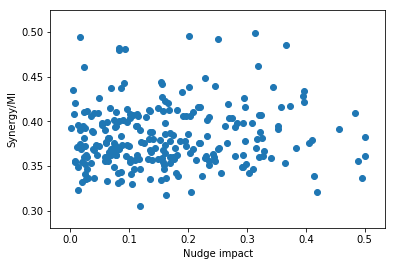

In [2]:
# create a network motif
motifs, indegree_avg = generator.generate_motifs(samplesize=500, no_nodes=3, numvalues=2, conflict_rule='totaleffect')
print("average indegree is "+str(indegree_avg))

# check which are high in synergy and have 0 impact
#for motif in motifs:
#    motif.evaluate_motif()
#    if measures.synergy_middleground(motif) > 1:
#        print(motif.grn_vars["rules"])
#        table = visualize.state_transition_table(motif, 'totaleffect')
#        display(HTML(tabulate.tabulate(table, tablefmt='html')))

# make a plot with WMS synergy
visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_middleground)

average indegree is 3.15333333333
failed to find the synergy


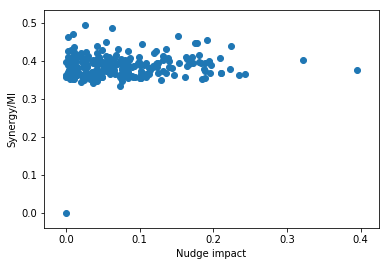

In [3]:
# create a network motif
motifs, indegree_avg = generator.generate_motifs(samplesize=500, no_nodes=3, numvalues=3, conflict_rule='totaleffect')
print("average indegree is "+str(indegree_avg))

# make a plot with WMS synergy
visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_middleground)

average indegree is 2.88933333333


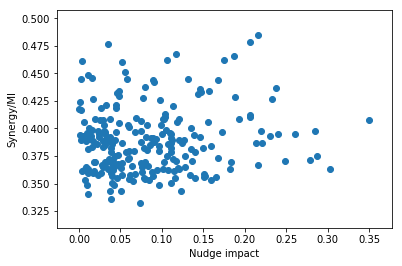

In [4]:
# create a network motif
motifs, indegree_avg = generator.generate_motifs(samplesize=500, no_nodes=3, numvalues=3, conflict_rule='totaleffect')
print("average indegree is "+str(indegree_avg))

# make a plot with WMS synergy
visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_middleground)

In [5]:
# create a network motif
#motifs, indegree_avg = generator.generate_motifs(samplesize=1, no_nodes=3, numvalues=5, conflict_rule='totaleffect')
#print("average indegree is "+str(indegree_avg))

# make a plot with WMS synergy
#visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_quax)

## More synergy in biological motif than in random

## Real GRN motif scores better than a random motif in memory

## Real GRN motif scores better than a random motif in single nudge resilience

## Real GRN motif scores similar to random motif in multiple nudge resilience

## There is a stronger than linear decrease in resilience when increasing the number of variables nudged in a biological GRN motif